In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from db.connection import q

In [2]:
sql = """
SELECT 
    ct.country_code,
    EXTRACT (YEAR FROM age(ct.birth_date)) AS age,
    rp.name AS risk_profile
FROM 
    public."Customer" AS ct
INNER JOIN 
    public."Risk_Profile" AS rp
ON
    ct.risk_profile = rp.id
WHERE 
    ct.deleted_at IS NULL
"""

In [3]:
df = q(sql)
df.head()

,country_code,age,risk_profile
0,US,31.0,moderate
1,US,33.0,moderate
2,GB,33.0,moderate
3,GB,33.0,moderate
4,FR,53.0,conservative


# Dataset Overview
Inspect schema, nulls, and data types to validate ingestion quality

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  100 non-null    object 
 1   age           100 non-null    float64
 2   risk_profile  100 non-null    object 
dtypes: float64(1), object(2)
memory usage: 2.5+ KB


# Customer Geographic Distribution
Understanding where customers are concentrated helps evaluate market exposure.

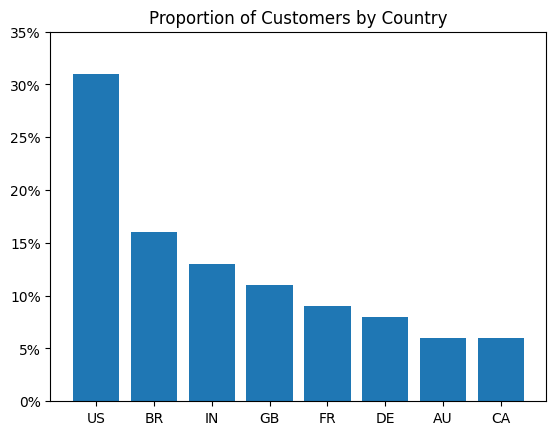

In [5]:
total_customer_by_country = df['country_code'].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.bar(total_customer_by_country.index, total_customer_by_country.values * 100)
ax.set_title('Proportion of Customers by Country')
y_ticks = ax.get_yticks()
y_formatted = [f'{value:.0f}%' for value in y_ticks]
ax.set_yticks(y_ticks, y_formatted)

plt.show()

In [6]:
total_customer_by_country

country_code
US    0.31
BR    0.16
IN    0.13
GB    0.11
FR    0.09
DE    0.08
AU    0.06
CA    0.06
Name: proportion, dtype: float64

# Risk profile geographic analysis

In [7]:
risk_per_country = (
    df.groupby(['country_code', 'risk_profile'])
    .size()
    .reset_index(name='count')
)

risk_per_country

,country_code,risk_profile,count
0,AU,aggressive,3
1,AU,moderate,3
2,BR,aggressive,7
3,BR,conservative,3
4,BR,moderate,6
5,CA,aggressive,2
6,CA,conservative,1
7,CA,moderate,3
8,DE,aggressive,3
9,DE,conservative,3


In [8]:
pivot = risk_per_country.pivot(
    index='country_code',
    columns='risk_profile',
    values='count'
).fillna(0)

pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot

risk_profile,aggressive,conservative,moderate
country_code,,,
US,8.0,7.0,16.0
BR,7.0,3.0,6.0
IN,7.0,2.0,4.0
GB,2.0,2.0,7.0
FR,2.0,5.0,2.0
DE,3.0,3.0,2.0
CA,2.0,1.0,3.0
AU,3.0,0.0,3.0


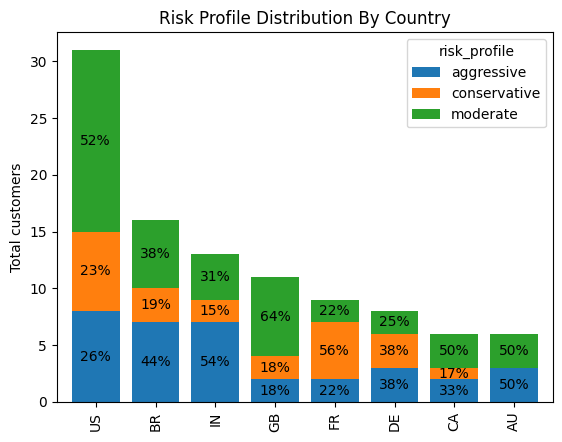

In [9]:
totals = pivot.sum(axis=1).sort_values(ascending=False)

ax = pivot.plot(kind='bar', stacked=True, width=.8)

for container in ax.containers:
    labels = []
    for bar, total in zip(container, totals):
        height = bar.get_height()
        if height == 0:
            labels.append('')
        else:
            pct = height / total * 100
            labels.append(f'{pct:.0f}%')

    ax.bar_label(container, labels=labels, label_type='center')

ax.set_title('Risk Profile Distribution By Country')
ax.set_ylabel('Total customers')
ax.set_xlabel('')
plt.show()

In [10]:
risk_profile_proportion = df['risk_profile'].value_counts(normalize=True)
risk_profile_proportion

risk_profile
moderate        0.43
aggressive      0.34
conservative    0.23
Name: proportion, dtype: float64

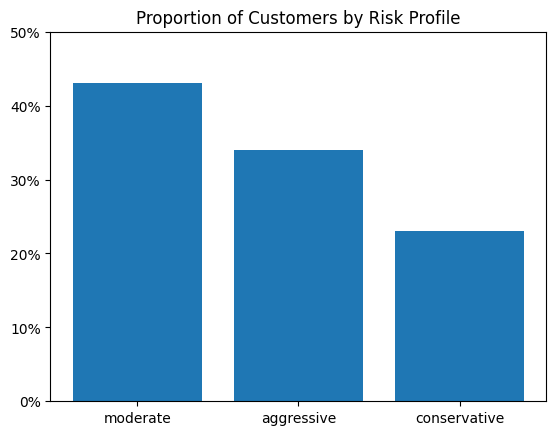

In [11]:
fig, ax = plt.subplots()
heights = risk_profile_proportion.values * 100

ax.bar(risk_profile_proportion.index, heights)
ax.set_title('Proportion of Customers by Risk Profile')
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks, [f'{v:.0f}%' for v in y_ticks])

plt.show()

# Customer Age Distribution
Age impacts risk tolerance, product suitability, and regulatory constraints.

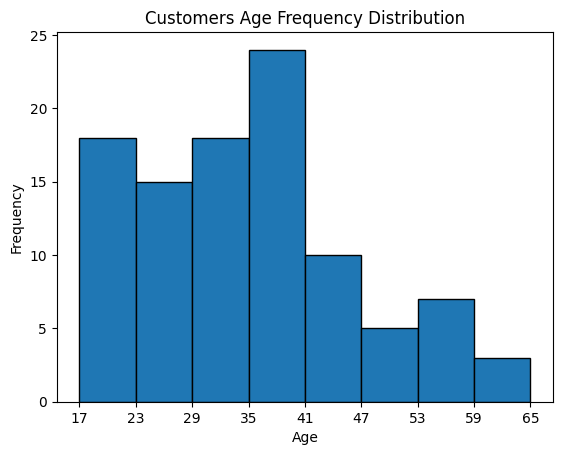

In [12]:
bins_age = np.ceil(np.histogram_bin_edges(df['age'], bins='fd'))

fig, ax = plt.subplots()
ax.hist(df['age'], bins=bins_age, edgecolor='black')
ax.set_xticks(bins_age)
ax.set_title('Customers Age Frequency Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

plt.show()

In [13]:
df['age'].describe()

count    100.00000
mean      34.79000
std       11.43828
min       17.00000
25%       26.00000
50%       34.00000
75%       40.25000
max       65.00000
Name: age, dtype: float64

In [14]:
df['age'].quantile(.9)

np.float64(50.300000000000026)

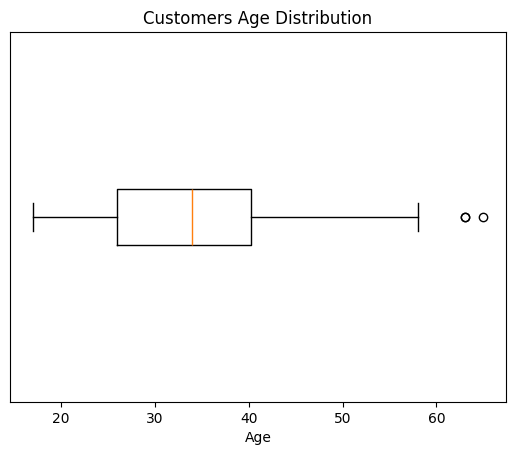

In [15]:
fig, ax = plt.subplots()
ax.boxplot(df['age'], orientation='horizontal')
ax.set_yticks([])
ax.set_xlabel('Age')
ax.set_title('Customers Age Distribution')

plt.show()

## Age distribution by Risk Profile

### Creating age segments

- 18–24 → Young Adults

- 25–34 → Emerging Professionals

- 35–44 → Established Professionals

- 45–54 → Peak Earners

- 55–64 → Pre-Retirees

- 65+ → Retirees

In [16]:
bins = [17, 24, 34, 44, 54, 64, 200]

df['age_segment'] = pd.cut(df['age'], bins, labels=[
    'Young Adults', 'Emerging Professionals', 'Established Professionals',
    'Peak Earners', 'Pre-Retirees', 'Retirees'
], include_lowest=True, right=True)

df.head()

,country_code,age,risk_profile,age_segment
0,US,31.0,moderate,Emerging Professionals
1,US,33.0,moderate,Emerging Professionals
2,GB,33.0,moderate,Emerging Professionals
3,GB,33.0,moderate,Emerging Professionals
4,FR,53.0,conservative,Peak Earners


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   country_code  100 non-null    object  
 1   age           100 non-null    float64 
 2   risk_profile  100 non-null    object  
 3   age_segment   100 non-null    category
dtypes: category(1), float64(1), object(2)
memory usage: 2.8+ KB


In [18]:
age_per_risk_profile = (
    df.groupby(['risk_profile', 'age_segment'], observed=False)
    .size()
    .reset_index(name='total')
)

age_per_risk_profile

,risk_profile,age_segment,total
0,aggressive,Young Adults,15
1,aggressive,Emerging Professionals,8
2,aggressive,Established Professionals,8
3,aggressive,Peak Earners,3
4,aggressive,Pre-Retirees,0
5,aggressive,Retirees,0
6,conservative,Young Adults,2
7,conservative,Emerging Professionals,3
8,conservative,Established Professionals,8
9,conservative,Peak Earners,6


In [19]:
contingency_table = age_per_risk_profile.pivot(
        index='risk_profile',
        columns='age_segment',
        values='total'
)
contingency_table

age_segment,Young Adults,Emerging Professionals,Established Professionals,Peak Earners,Pre-Retirees,Retirees
risk_profile,,,,,,
aggressive,15,8,8,3,0,0
conservative,2,3,8,6,3,1
moderate,5,18,14,4,2,0


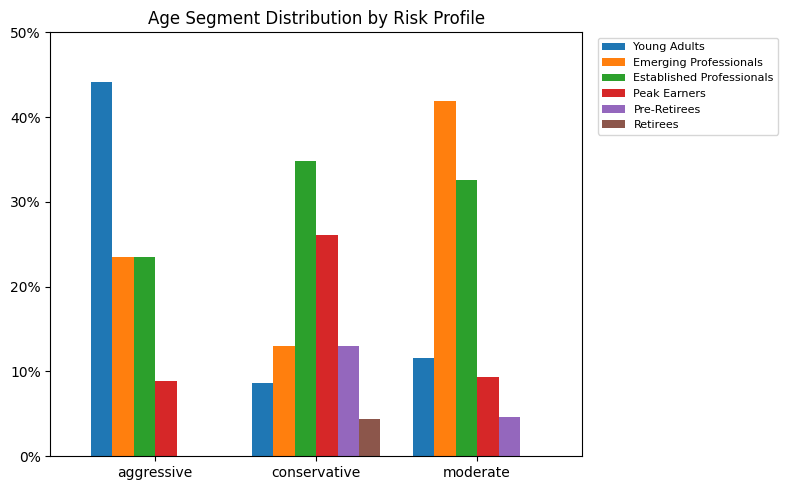

In [20]:
ax = (
    contingency_table   
    # normalize to get proportional info
    .div(contingency_table.sum(axis=1), axis=0)

    .plot(kind='bar', width=0.8)
)

ax.legend(
    title='',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize='8'
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0)
ax.set_xlabel('')
ax.set_title('Age Segment Distribution by Risk Profile')

y_ticks = ax.get_yticks()
formatted_yticks = [f'{(v*100):.0f}%' for v in y_ticks]
ax.set_yticks(y_ticks, formatted_yticks)

fig = ax.get_figure()
fig.set_size_inches(8, 5)

plt.tight_layout()
plt.show()

## Age Segment Distribution

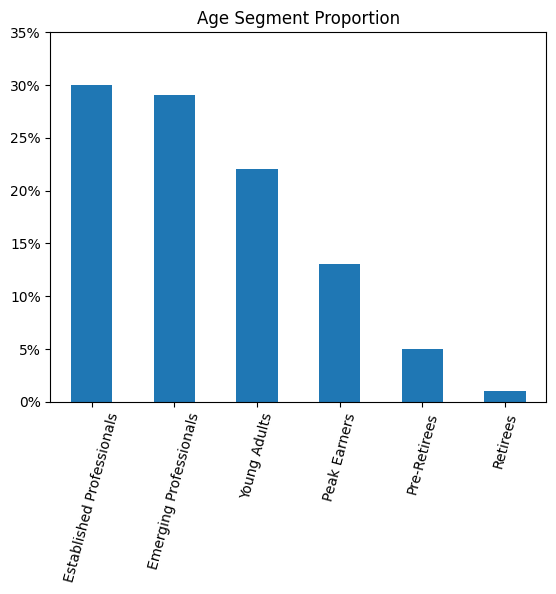

In [21]:
ax = df['age_segment'].value_counts(normalize=True).plot(kind='bar')

ax.set_title('Age Segment Proportion')
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=75)

y_ticks = ax.get_yticks()
formatted_yticks = [f'{(v*100):.0f}%' for v in y_ticks]
ax.set_yticks(y_ticks, formatted_yticks)

plt.show()